In [2]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from scipy import signal

import os
from glob import glob
import matplotlib.pyplot as plt

Folder Paths

In [3]:
greenPath = './ppg_GREEN/'
redPath = './ppg_RED/'
irPath = './ppg_IR/'


BandPass Filter

In [4]:
# BandPass Filter Parameters

sampling_freq = 100 # Hz

lowcut = 0.5                         # Lower Cutoff Frequency in Hz
highcut = 35.0                       # Higher Cutoff Frequency in Hz
nyquist_freq = 0.5 * sampling_freq   # Nyquist frequency in Hz
order = 4                            # Filter order

# Design Bandpass Filter
b, a = signal.butter(order, [lowcut / nyquist_freq, highcut / nyquist_freq], btype='band')

BandPass Filter : AC Component Calculation

BANDPASS

AC Component of ./ppg_GREEN\green1_AR.csv : 8.982103450971607
AC Component of ./ppg_GREEN\green1_SB.csv : 29.073931983148398
AC Component of ./ppg_GREEN\green2_AR.csv : 21.275531301550288
AC Component of ./ppg_GREEN\green2_SB.csv : 71.8343320381615
AC Component of ./ppg_GREEN\green3_AR.csv : 22.569711418914096
AC Component of ./ppg_GREEN\green3_SB.csv : 39.0949640077012
AC Component of ./ppg_GREEN\green4_AR.csv : 58.18900613314773
AC Component of ./ppg_GREEN\green4_SB.csv : 40.682923380326514
AC Component of ./ppg_GREEN\green5_AR.csv : 47.36919706579838
AC Component of ./ppg_GREEN\green5_SB.csv : 36.83184788650517
---------------------------------------------------
---------------------------------------------------
Average AC Component using  GREEN wave for  AR is : 31.67710987407642
Average AC Component using  GREEN wave for  SB is : 43.50359985916856
---------------------------------------------------
Average AC Component of Trials for GREEN wave using Bandpass is : 37.590

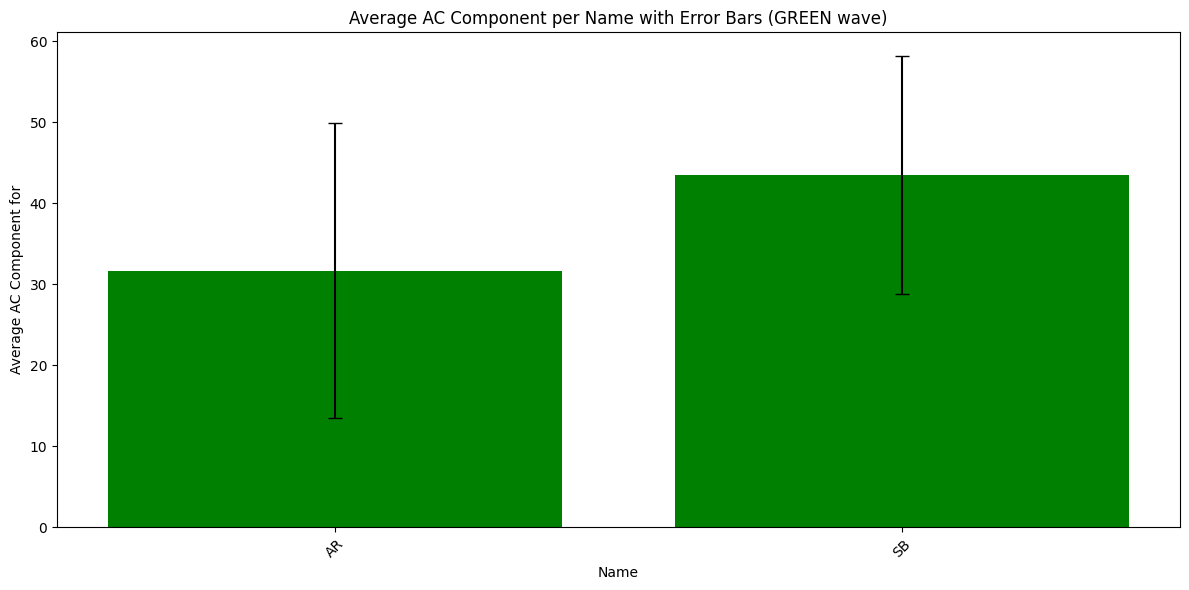

In [5]:
# Average AC Component of Trials
overallAvgAC = 0
numOfFiles = 0
color = ''

print("BANDPASS\n")

subjects = {}

for file in glob(greenPath + '*.csv'):
    color = file.split('_')[1]
    color = color.split('\\')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Remove the DC Component
    dc_component = np.mean(smoothed_ppg_1)
    ppg_ac= smoothed_ppg_1 - dc_component

    # Calculate the AC Component
    peaks, _ = find_peaks(ppg_ac)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-ppg_ac)  # Detect troughs by inverting signal
    ac_component = ppg_ac[peaks].mean() - ppg_ac[troughs].mean()

    # Add to People Dictionary
    if name not in subjects.keys():
        subjects[name] = []
    
    # Add the number to the list associated with the name
    subjects[name].append(ac_component)

    # Add to avg
    overallAvgAC += ac_component

    # Print the AC Component for trial
    print(f'AC Component of {file} : {ac_component}')

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgAC = average = sum(j) / len(j)
    print("Average AC Component using ", color, "wave for ", i, "is :", avgAC)

print('---------------------------------------------------')
print(f'Average AC Component of Trials for {color} wave using Bandpass is : {overallAvgAC / numOfFiles}')



# Create a dictionary to store the average AC components and standard deviations for each name
avg_ac_components = {}
std_dev_ac_components = {}

for name, ac_list in subjects.items():
    avg_ac_components[name] = sum(ac_list) / len(ac_list)
    std_dev_ac_components[name] = np.std(ac_list)

# Create a bar graph with error bars
names = list(avg_ac_components.keys())
ac_values = list(avg_ac_components.values())
std_dev_values = list(std_dev_ac_components.values())



plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.xlabel('Name')
plt.ylabel('Average AC Component for')
plt.title(f'Average AC Component per Name with Error Bars ({color} wave)') # Add color variable to title
if color == 'IR':
    color = 'm'
plt.bar(names, ac_values, yerr=std_dev_values, capsize=5, color=color)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()



BandPass Filter : Perfusion Index Calculation

BANDPASS

---------------------------------------------------
---------------------------------------------------
Average Perfusion Component using  RED wave is for  AR  is :  0.046402377843374254
Average Perfusion Component using  RED wave is for  SB  is :  0.037489863469776216
---------------------------------------------------
Average Perfusion Component of Trials for RED wave using Bandpass is : 0.041946120656575235


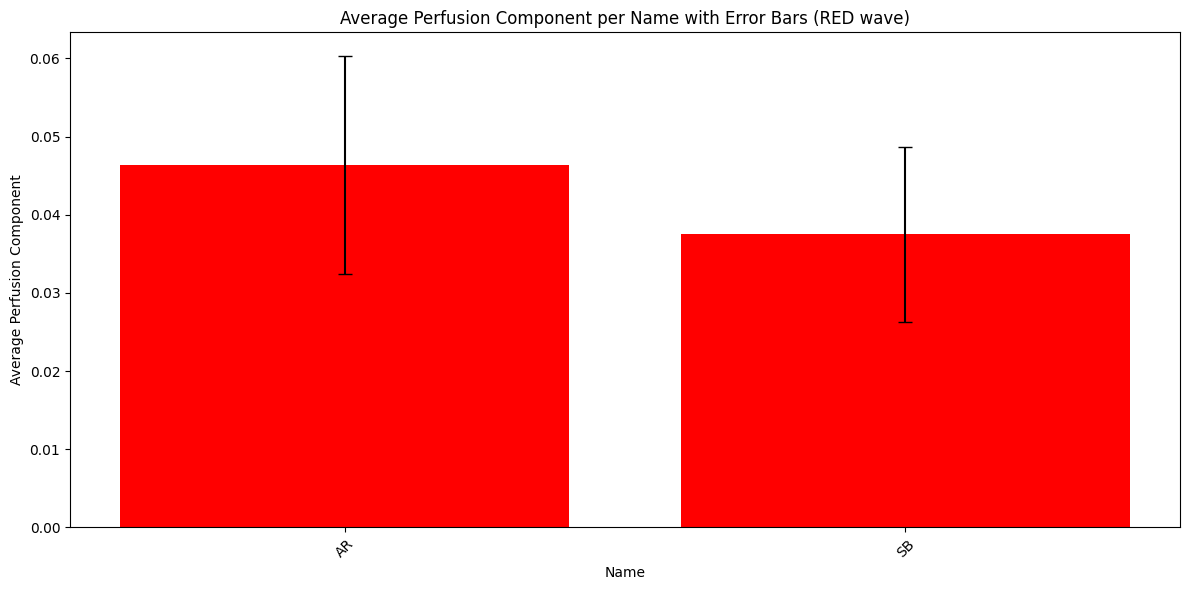

In [6]:
# Average Perfusion Index of Trials
overallAvgPerfusion = 0
numOfFiles = 0
color = ''

subjects = {}

print("BANDPASS\n")

for file in glob(redPath + '*.csv'):
    color = file.split('_')[1]
    color = color.split('\\')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    smoothed_ppg_1 = noisy_ppgOne

    # Find peaks and troughs-------------------------------------------------------------------------------
    peaks, _ = find_peaks(smoothed_ppg_1)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-smoothed_ppg_1)  # Detect troughs by inverting signal

    # Calculate Pulse Amplitude
    if len(peaks) > 0 and len(troughs) > 0:
        pulse_amplitude = smoothed_ppg_1[peaks].mean() - smoothed_ppg_1[troughs].mean()
    else:
        pulse_amplitude = np.nan

    # Calculate Baseline Amplitude
    baseline_amplitude = smoothed_ppg_1.mean()

    # Calculate Perfusion Index
    if not np.isnan(pulse_amplitude) and not np.isnan(baseline_amplitude):
        perfusion_index = (pulse_amplitude / baseline_amplitude) * 100
    else:
        perfusion_index = np.nan

    # Add to People Dictionary
    if name not in subjects.keys():
        subjects[name] = []
    
    # Add the number to the list associated with the name
    subjects[name].append(perfusion_index)

    # Add to avg
    overallAvgPerfusion += perfusion_index

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgPerfusion = average = sum(j) / len(j)
    print("Average Perfusion Component using ", color, "wave is for ", i, " is : ", avgPerfusion)

print('---------------------------------------------------')
print(f'Average Perfusion Component of Trials for {color} wave using Bandpass is : {overallAvgPerfusion / numOfFiles}')


# Create a dictionary to store the average AC components and standard deviations for each name
avg_perfusion_components = {}
std_dev_perfusion_components = {}

for name, p_list in subjects.items():
    avg_perfusion_components[name] = sum(p_list) / len(p_list)
    std_dev_perfusion_components[name] = np.std(p_list)

# Create a bar graph with error bars
names = list(avg_perfusion_components.keys())
p_values = list(avg_perfusion_components.values())
std_dev_values = list(std_dev_perfusion_components.values())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.xlabel('Name')
plt.ylabel('Average Perfusion Component')
plt.title(f'Average Perfusion Component per Name with Error Bars ({color} wave)') # Add color variable to title
if color == 'IR':
    color = 'm'
plt.bar(names, p_values, yerr=std_dev_values, capsize=5, color=color)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

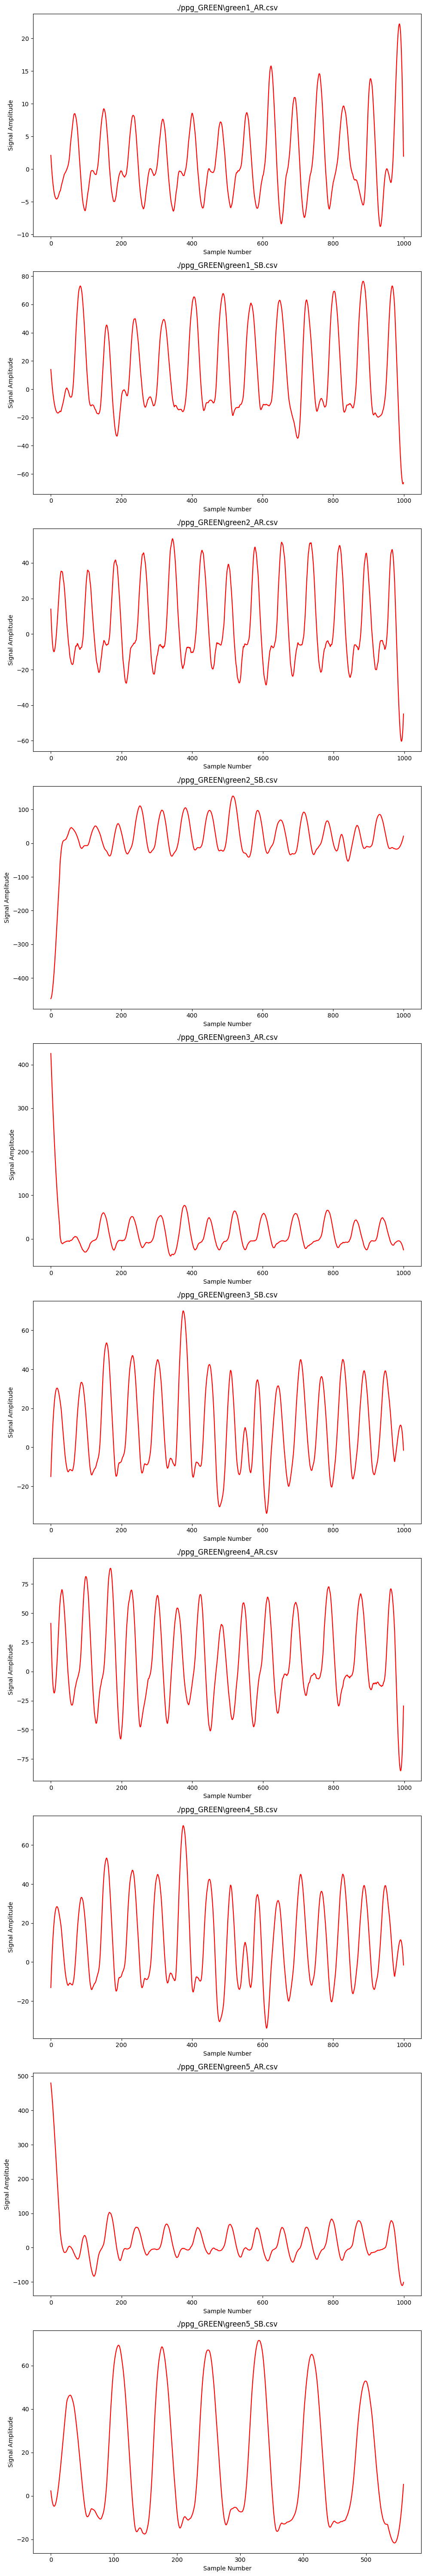

In [13]:
# for file in glob(greenPath + '*.csv'):
#     numOfFiles += 1
#     ppg_data = pd.read_csv(file)
#     noisy_ppg_1 = ppg_data["PPG1"].values
#     # Apply BandPass Filter to noisy ECG Signal
#     filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

#     # Baseline Correction
#     baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
#     corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

#     # Smoothing
#     smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)
#     # Create a figure with subplots
#     #fig, axs = plt.subplots(3, 1, figsize=(12, 10))

import glob

# Get the list of files to determine the number of subplots
files = glob.glob(greenPath + '*.csv')
numOfFiles = len(files)

# Create a figure with subplots, one per row
fig, axs = plt.subplots(numOfFiles, 1, figsize=(10, 6 * numOfFiles))  # Adjust the figure size as needed


# Ensure axs is an array even if there is only one file
if numOfFiles == 1:
    axs = [axs]

for idx, file in enumerate(files):
    ppg_data = pd.read_csv(file)
    noisy_ppg_1 = ppg_data["PPG1"].values

    # Assuming 'b' and 'a' are defined for the bandpass filter
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppg_1)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Plot the smoothed signal on its subplot
    axs[idx].plot(smoothed_ppg_1, color=color)
    axs[idx].set_title(f'{file}')
    axs[idx].set_xlabel('Sample Number')
    axs[idx].set_ylabel('Signal Amplitude')

plt.tight_layout()
plt.show()

Highpass Filter

In [ ]:
# HighPass Filter Parameters
sampling_freq = 100 # Hz

cutoff = 0.5                         # Cutoff Frequency in Hz
nyquist_freq = 0.5 * sampling_freq   # Nyquist frequency in Hz
order = 4                            # Filter order

# Design Bandpass Filter
b, a = signal.butter(order, cutoff / nyquist_freq, btype='high')

HighPass Filter : AC Component Calculation

HIGHPASS

AC Component of ./ppg_GREEN/green2_SB.csv : 49.288815860012875
AC Component of ./ppg_GREEN/green4_AR.csv : 55.1760139233428
AC Component of ./ppg_GREEN/green2_AR.csv : 19.878579409679308
AC Component of ./ppg_GREEN/green4_SB.csv : 28.913794549064946
AC Component of ./ppg_GREEN/green1_SB.csv : 21.704442621075753
AC Component of ./ppg_GREEN/green5_AR.csv : 45.38890454458642
AC Component of ./ppg_GREEN/green3_SB.csv : 28.888159449449542
AC Component of ./ppg_GREEN/green1_AR.csv : 7.4141202020944466
AC Component of ./ppg_GREEN/green5_SB.csv : 20.54730625025945
AC Component of ./ppg_GREEN/green3_AR.csv : 21.37267447851141
---------------------------------------------------
---------------------------------------------------
Average AC Component for  SB is : 374.5851886928683
Average AC Component for  AR is : 430.65944912996883
---------------------------------------------------
Average AC Component of Trials using Bandpass is : 29.857281128807692


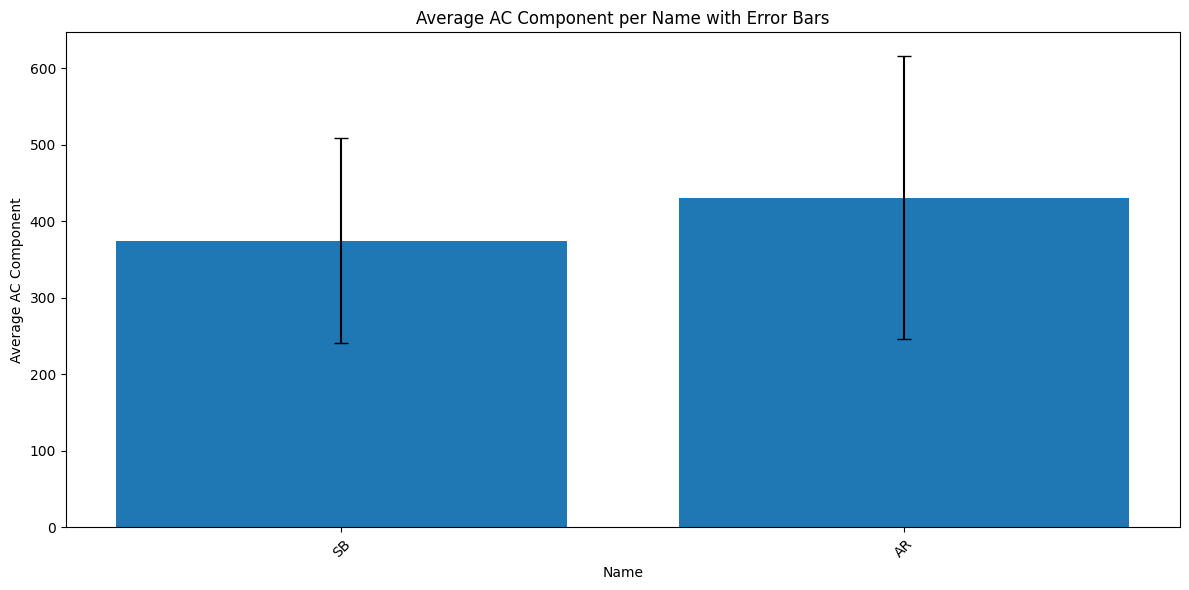

In [ ]:
# Average AC Component of Trials
overallAvgAC = 0
numOfFiles = 0
color = ''

print("HIGHPASS\n")

for file in glob(greenPath + '*.csv'):

    color = file.split('_')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Remove the DC Component
    dc_component = np.mean(smoothed_ppg_1)
    ppg_ac= smoothed_ppg_1 - dc_component

    # Calculate the AC Component
    peaks, _ = find_peaks(ppg_ac)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-ppg_ac)  # Detect troughs by inverting signal
    ac_component = ppg_ac[peaks].mean() - ppg_ac[troughs].mean()

    # Add to avg
    overallAvgAC += ac_component

    # Print the AC Component for trial
    print(f'AC Component of {file} : {ac_component}')

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgAC = average = sum(j) / len(j)
    print("Average AC Component for ", i, "is :", avgAC)

print('---------------------------------------------------')
print(f'Average AC Component of Trials using Bandpass is : {overallAvgAC / numOfFiles}')



# Create a dictionary to store the average AC components and standard deviations for each name
avg_ac_components = {}
std_dev_ac_components = {}

for name, ac_list in subjects.items():
    avg_ac_components[name] = sum(ac_list) / len(ac_list)
    std_dev_ac_components[name] = np.std(ac_list)

# Create a bar graph with error bars
names = list(avg_ac_components.keys())
ac_values = list(avg_ac_components.values())
std_dev_values = list(std_dev_ac_components.values())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(names, ac_values, yerr=std_dev_values, capsize=5)
plt.xlabel('Name')
plt.ylabel('Average AC Component')
plt.title('Average AC Component per Name with Error Bars')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()


HighPass Filter : Perfusion Index Calculation

HIGHPASS

---------------------------------------------------
---------------------------------------------------
---------------------------------------------------
Average Perfusion Component of Trials using Bandpass is : 393.18190242078606


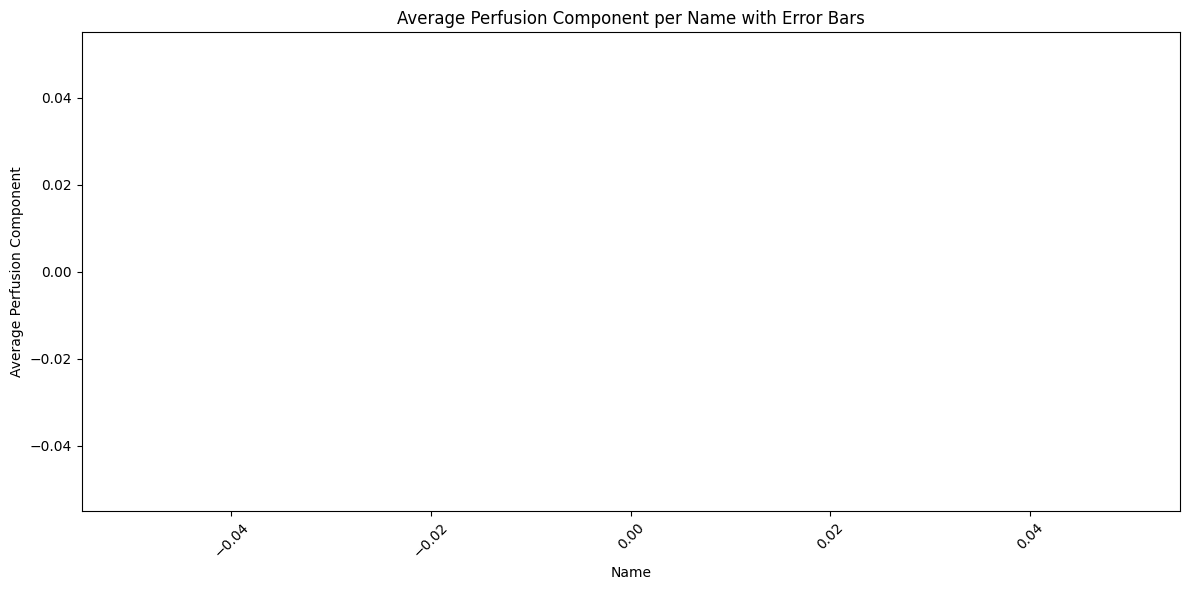

In [ ]:
# Average Perfusion Index of Trials
overallAvgPerfusion = 0
numOfFiles = 0

subjects = {}

print("HIGHPASS\n")

for file in glob(greenPath + '*.csv'):

    color = file.split('_')[0]
    name = file.split('_')[2]
    name = name.split('.')[0]

    numOfFiles += 1
    ppg_data = pd.read_csv(file)
    noisy_ppgOne = ppg_data["PPG1"].values
    # Apply BandPass Filter to noisy ECG Signal
    filtered_ppg_1 = signal.filtfilt(b, a, noisy_ppgOne)

    # Baseline Correction
    baseline_ppg_1 = signal.medfilt(filtered_ppg_1, kernel_size=51)  # Apply a median filter as a baseline
    corrected_ppg_1 = filtered_ppg_1 - baseline_ppg_1

    # Smoothing
    smoothed_ppg_1 = signal.savgol_filter(corrected_ppg_1, window_length=51, polyorder=3)

    # Find peaks and troughs-------------------------------------------------------------------------------
    peaks, _ = find_peaks(smoothed_ppg_1)  # Adjust height threshold as needed
    troughs, _ = find_peaks(-smoothed_ppg_1)  # Detect troughs by inverting signal

    # Calculate Pulse Amplitude
    if len(peaks) > 0 and len(troughs) > 0:
        pulse_amplitude = smoothed_ppg_1[peaks].mean() - smoothed_ppg_1[troughs].mean()
    else:
        pulse_amplitude = np.nan

    # Calculate Baseline Amplitude
    baseline_amplitude = smoothed_ppg_1.mean()

    # Calculate Perfusion Index
    if not np.isnan(pulse_amplitude) and not np.isnan(baseline_amplitude):
        perfusion_index = (pulse_amplitude / baseline_amplitude) * 100
    else:
        perfusion_index = np.nan

    # Add to avg
    overallAvgPerfusion += perfusion_index

print('---------------------------------------------------')
print('---------------------------------------------------')
for i,j in subjects.items():
    avgPerfusion = average = sum(j) / len(j)
    print("Average Perfusion Component for ", i, "is :", avgPerfusion)

print('---------------------------------------------------')
print(f'Average Perfusion Component of Trials using Bandpass is : {overallAvgPerfusion / numOfFiles}')


# Create a dictionary to store the average AC components and standard deviations for each name
avg_perfusion_components = {}
std_dev_perfusion_components = {}

for name, p_list in subjects.items():
    avg_perfusion_components[name] = sum(p_list) / len(p_list)
    std_dev_perfusion_components[name] = np.std(p_list)

# Create a bar graph with error bars
names = list(avg_perfusion_components.keys())
p_values = list(avg_perfusion_components.values())
std_dev_values = list(std_dev_perfusion_components.values())

plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.bar(names, p_values, yerr=std_dev_values, capsize=5)
plt.xlabel('Name')
plt.ylabel('Average Perfusion Component')
plt.title('Average Perfusion Component per Name with Error Bars')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

Convert Results to Readable Format